## Import Library

In [64]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [65]:
# !pip install transformers

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import glob
import shutil
import random
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import get_cosine_schedule_with_warmup
from transformers import SegformerForSemanticSegmentation

In [67]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


## Class Dataset

In [68]:
class BreastCancerDataset(Dataset):
    def __init__(self, root='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', split="train", transform=None):
        self.categories = ["benign", "malignant", "normal"]
        self.transform = transform
        self.path = glob.glob("{}/*/*_mask.png".format(root))

        random.seed(159)
        random.shuffle(self.path)

        total_len = len(self.path)
        train_end = int(total_len * 0.70)
        val_end = int(total_len * 0.85)
        if split == "train":
            self.path = self.path[:train_end]
        elif split == "val":
            self.path = self.path[train_end:val_end]
        elif split == "test":
            self.path = self.path[val_end:]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        image = cv2.imread(self.path[index].replace("_mask.png", ".png"))
        mask = cv2.imread(self.path[index], cv2.IMREAD_GRAYSCALE)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask[mask == 255] = 1

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        return image.float(), mask.float()

In [69]:
size = 512
train_transform = A.Compose([
    A.Resize(size, size),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.HorizontalFlip(),
    A.Perspective(scale=(0.05, 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])
    # A.RandomRotate90(),
    # A.GaussianBlur(),
    # A.CoarseDropout(max_height=25, max_width=25, fill_value=255),
    # A.ElasticTransform(alpha=1.0),

test_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

## UnNormalized

In [70]:
class UnNormalized(object):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unNorm = UnNormalized()

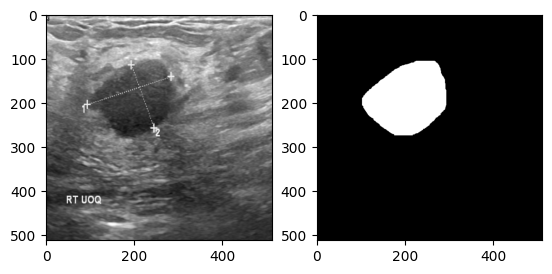

In [71]:
train_dataset = BreastCancerDataset(split="train", transform=train_transform)
val_dataset = BreastCancerDataset(split="val", transform=test_transform)
test_dataset = BreastCancerDataset(split="test", transform=test_transform)

image, mask = train_dataset[random.randint(1, len(train_dataset))]
plt.subplot(1, 2, 1)
plt.imshow(unNorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

## AverageMeter

In [72]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n = 1):
        self.val += val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Show Loss

In [73]:
def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Val Loss')
    plt.title('Training and Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
    if val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, val_mean_iou, 'b', label='Val Mean IoU')
        plt.title('Training and Val Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
    if val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, val_dice_score, 'b', label='Val Dice Score')
        plt.title('Training and Val Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Calculate Intersection And Union

In [74]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

## Train

In [75]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear')

In [76]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [77]:
def train(train_dataset, val_dataset, num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # train_dataset = BreastCancerDataset(transform=train_transform)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )
    
    # val_dataset = BreastCancerDataset(is_train=False, transform=test_transform)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=n_workers
    )

    version = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(version)
    
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-4)
    
    num_batch = len(train_loader)
    
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_batch*epochs, power=0.9)

    if os.path.isdir(checkpoint):
        shutil.rmtree(checkpoint)
    os.makedirs(checkpoint)
    
    if not os.path.isdir(saved_model):
        os.makedirs(saved_model)
    
    writer = SummaryWriter(checkpoint)
    
    train_loss = []
    val_loss = []
    val_mIoU = []
    val_mDice = []
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    train_loss_meter = AverageMeter()
    val_loss_meter = AverageMeter()
    
    no_improvement_counter = 0
    patience = 5
    best_mIoU = -1
    
    for epoch in range(epochs):
        model.train()
        train_loss_meter.reset()
        val_loss_meter.reset()
        intersection_meter.reset()
        union_meter.reset()
        
        progress_bar = tqdm(train_loader, colour='cyan')
        
        for i, (image, mask) in enumerate(progress_bar):
            image, mask = image.to(device), mask.to(device)
            
            output = model(image).logits
            output = upsample(output).squeeze()
            loss = criterion(output, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_meter.update(loss.item())
            progress_bar.set_description(f"Train | Epoch {epoch + 1}/{epochs} | Loss {train_loss_meter.avg:.4f} | lr {optimizer.param_groups[0]['lr']}")
            writer.add_scalar("Train/Loss AVG", train_loss_meter.avg, num_batch * epoch + i)
            writer.add_scalar("Train/Loss", loss.item(), num_batch * epoch + i)
            scheduler.step()
        
        model.eval()
        with torch.no_grad():
            progress_bar = tqdm(iterable=val_loader, colour='yellow')
            
            for image, mask in progress_bar:
                image, mask = image.to(device), mask.to(device)
                
                output = model(image).logits
                output = upsample(output).squeeze()
                loss = criterion(output, mask)
                
                val_loss_meter.update(loss.item())
                output[output>=0.5] = 1
                output[output<0.5] = 0
                output = output.long()
                mask = mask.long()
                
                intersection, union, target = intersectionAndUnionGPU(output, mask, 2)           
                intersection_meter.update(intersection)
                union_meter.update(union)
                
                iou = intersection / (union + 1e-10)
                mean_iou = np.mean(iou.cpu().numpy())
                dice = 2 * intersection / (intersection + union + 1e-10)

                dice_value = dice.mean().item()
                
                intersection_meter.update(intersection)
                union_meter.update(union)
                val_loss_meter.update(loss.item())
                
                progress_bar.set_description(f"Val | Loss {loss.item():.4f} | mIoU: {mean_iou:.4f} | dice: {dice_value:.4f}")
            
            
            iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
            dice_class = 2 * intersection_meter.sum / (intersection_meter.sum + union_meter.sum + 1e-10)
            
            mIoU = iou_class.mean().item()
            mDice = dice_class.mean().item()
            print(f"Val | Loss {val_loss_meter.avg:.4f} | mIoU: {mIoU:.4f} | dice: {mDice:.4f}")
            
            writer.add_scalar("Val/Loss", val_loss_meter.avg, epoch)
            writer.add_scalar("Val/mIoU", mIoU, epoch)
            writer.add_scalar("Val/dice", mDice, epoch)
            
            checkpoint_data = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "mIoU": mIoU,
                "mDice": mDice
            }
            
            torch.save(checkpoint_data, os.path.join(saved_model, "last.pt"))
            
            if mIoU > best_mIoU:
                best_mIoU = mIoU
                torch.save(checkpoint_data, os.path.join(saved_model, "best.pt"))
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1
              
            train_loss.append(train_loss_meter.avg)
            val_loss.append(val_loss_meter.avg)
            val_mIoU.append(mIoU)
            val_mDice.append(mDice)
            
            if no_improvement_counter > patience:
                print("Early stopping!")
                break
    
    plot_segmentation_metrics(train_loss, val_loss, None, val_mIoU, None, val_mDice)


In [78]:
torch.cuda.empty_cache()

import gc
gc.collect()

59430

2


Train | Epoch 1/40 | Loss 0.4619 | lr 9.77798521260169e-05: 100%|██████████| 69/69 [03:02<00:00,  2.65s/it] 
Val | Loss 0.2834 | mIoU: 0.6450 | dice: 0.7572: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Val | Loss 0.2016 | mIoU: 0.7376 | dice: 0.8304


Train | Epoch 2/40 | Loss 0.2087 | lr 9.552131392330785e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
Val | Loss 0.2384 | mIoU: 0.6684 | dice: 0.7787: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.1246 | mIoU: 0.7720 | dice: 0.8578


Train | Epoch 3/40 | Loss 0.1524 | lr 9.325682592203811e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2733 | mIoU: 0.6477 | dice: 0.7590: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.1223 | mIoU: 0.7585 | dice: 0.8472


Train | Epoch 4/40 | Loss 0.1254 | lr 9.098621102391091e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it]
Val | Loss 0.2221 | mIoU: 0.6954 | dice: 0.8027: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.0987 | mIoU: 0.7774 | dice: 0.8620


Train | Epoch 5/40 | Loss 0.1121 | lr 8.870928178587884e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
Val | Loss 0.2004 | mIoU: 0.7692 | dice: 0.8612: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Val | Loss 0.0897 | mIoU: 0.8360 | dice: 0.9046


Train | Epoch 6/40 | Loss 0.1015 | lr 8.64258395024974e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.2972 | mIoU: 0.6302 | dice: 0.7415: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Val | Loss 0.0985 | mIoU: 0.7538 | dice: 0.8432


Train | Epoch 7/40 | Loss 0.0955 | lr 8.413567317743088e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.1995 | mIoU: 0.7011 | dice: 0.8078: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.0988 | mIoU: 0.8165 | dice: 0.8912


Train | Epoch 8/40 | Loss 0.0780 | lr 8.183855836694984e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2229 | mIoU: 0.7534 | dice: 0.8497: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Val | Loss 0.0808 | mIoU: 0.8452 | dice: 0.9108


Train | Epoch 9/40 | Loss 0.0788 | lr 7.95342558749754e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.2439 | mIoU: 0.6645 | dice: 0.7755: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Val | Loss 0.0810 | mIoU: 0.8203 | dice: 0.8937


Train | Epoch 10/40 | Loss 0.0774 | lr 7.72225102751984e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.2715 | mIoU: 0.6431 | dice: 0.7541: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Val | Loss 0.0728 | mIoU: 0.8220 | dice: 0.8947


Train | Epoch 11/40 | Loss 0.0708 | lr 7.49030482308113e-05: 100%|██████████| 69/69 [03:02<00:00,  2.65s/it] 
Val | Loss 0.2118 | mIoU: 0.7298 | dice: 0.8312: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.0754 | mIoU: 0.8413 | dice: 0.9082


Train | Epoch 12/40 | Loss 0.0616 | lr 7.257557657617906e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
Val | Loss 0.2041 | mIoU: 0.7540 | dice: 0.8496: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.0719 | mIoU: 0.8424 | dice: 0.9089


Train | Epoch 13/40 | Loss 0.0613 | lr 7.023978011698385e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it]
Val | Loss 0.1930 | mIoU: 0.7538 | dice: 0.8495: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.0678 | mIoU: 0.8463 | dice: 0.9114


Train | Epoch 14/40 | Loss 0.0601 | lr 6.789531909553104e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
Val | Loss 0.1812 | mIoU: 0.7663 | dice: 0.8588: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.0694 | mIoU: 0.8438 | dice: 0.9098


Train | Epoch 15/40 | Loss 0.0579 | lr 6.554182625536082e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.3075 | mIoU: 0.6237 | dice: 0.7390: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.0790 | mIoU: 0.8141 | dice: 0.8894


Train | Epoch 16/40 | Loss 0.0543 | lr 6.317890342319167e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2484 | mIoU: 0.7382 | dice: 0.8379: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Val | Loss 0.0656 | mIoU: 0.8551 | dice: 0.9172


Train | Epoch 17/40 | Loss 0.0482 | lr 6.080611750531918e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it] 
Val | Loss 0.2000 | mIoU: 0.7736 | dice: 0.8647: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Val | Loss 0.0643 | mIoU: 0.8614 | dice: 0.9213


Train | Epoch 18/40 | Loss 0.0469 | lr 5.8422995768216605e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
Val | Loss 0.3512 | mIoU: 0.6344 | dice: 0.7456: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.1107 | mIoU: 0.7796 | dice: 0.8637


Train | Epoch 19/40 | Loss 0.0461 | lr 5.602902023683254e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it] 
Val | Loss 0.2362 | mIoU: 0.7453 | dice: 0.8433: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Val | Loss 0.0668 | mIoU: 0.8650 | dice: 0.9236


Train | Epoch 20/40 | Loss 0.0459 | lr 5.362362099552587e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.2101 | mIoU: 0.7557 | dice: 0.8513: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.0690 | mIoU: 0.8586 | dice: 0.9195


Train | Epoch 21/40 | Loss 0.0434 | lr 5.120616811070571e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.2335 | mIoU: 0.7490 | dice: 0.8461: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.0683 | mIoU: 0.8567 | dice: 0.9182


Train | Epoch 22/40 | Loss 0.0388 | lr 4.877596180363374e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it] 
Val | Loss 0.2458 | mIoU: 0.7484 | dice: 0.8455: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.0714 | mIoU: 0.8570 | dice: 0.9185


Train | Epoch 23/40 | Loss 0.0392 | lr 4.633222037530689e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.2258 | mIoU: 0.7681 | dice: 0.8601: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.0714 | mIoU: 0.8609 | dice: 0.9210


Train | Epoch 24/40 | Loss 0.0394 | lr 4.3874065205639255e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2678 | mIoU: 0.6534 | dice: 0.7659: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Val | Loss 0.0756 | mIoU: 0.8344 | dice: 0.9034


Train | Epoch 25/40 | Loss 0.0404 | lr 4.14005018892073e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it]  
Val | Loss 0.2372 | mIoU: 0.7522 | dice: 0.8487: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.0683 | mIoU: 0.8657 | dice: 0.9241


Train | Epoch 26/40 | Loss 0.0390 | lr 3.891039618595279e-05: 100%|██████████| 69/69 [03:03<00:00,  2.65s/it] 
Val | Loss 0.2438 | mIoU: 0.7505 | dice: 0.8477: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.0695 | mIoU: 0.8612 | dice: 0.9212


Train | Epoch 27/40 | Loss 0.0413 | lr 3.640244288514375e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.2363 | mIoU: 0.7735 | dice: 0.8647: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.0714 | mIoU: 0.8632 | dice: 0.9225


Train | Epoch 28/40 | Loss 0.0356 | lr 3.387512478116071e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.2617 | mIoU: 0.7358 | dice: 0.8363: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.0722 | mIoU: 0.8563 | dice: 0.9180


Train | Epoch 29/40 | Loss 0.0334 | lr 3.13266575222196e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]  
Val | Loss 0.2397 | mIoU: 0.7664 | dice: 0.8595: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Val | Loss 0.0711 | mIoU: 0.8674 | dice: 0.9252


Train | Epoch 30/40 | Loss 0.0315 | lr 2.8754913717105808e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it]
Val | Loss 0.2473 | mIoU: 0.7610 | dice: 0.8557: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Val | Loss 0.0711 | mIoU: 0.8652 | dice: 0.9238


Train | Epoch 31/40 | Loss 0.0379 | lr 2.6157315599174043e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2350 | mIoU: 0.7609 | dice: 0.8553: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.0748 | mIoU: 0.8435 | dice: 0.9095


Train | Epoch 32/40 | Loss 0.0327 | lr 2.3530678186229455e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2392 | mIoU: 0.7606 | dice: 0.8552: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Val | Loss 0.0725 | mIoU: 0.8453 | dice: 0.9108


Train | Epoch 33/40 | Loss 0.0312 | lr 2.0870970855408858e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
Val | Loss 0.2474 | mIoU: 0.7643 | dice: 0.8580: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.0712 | mIoU: 0.8578 | dice: 0.9190


Train | Epoch 34/40 | Loss 0.0310 | lr 1.8172936671867068e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2670 | mIoU: 0.7560 | dice: 0.8518: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Val | Loss 0.0775 | mIoU: 0.8423 | dice: 0.9087


Train | Epoch 35/40 | Loss 0.0326 | lr 1.5429445368201524e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2613 | mIoU: 0.7601 | dice: 0.8548: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.0737 | mIoU: 0.8496 | dice: 0.9136
Early stopping!


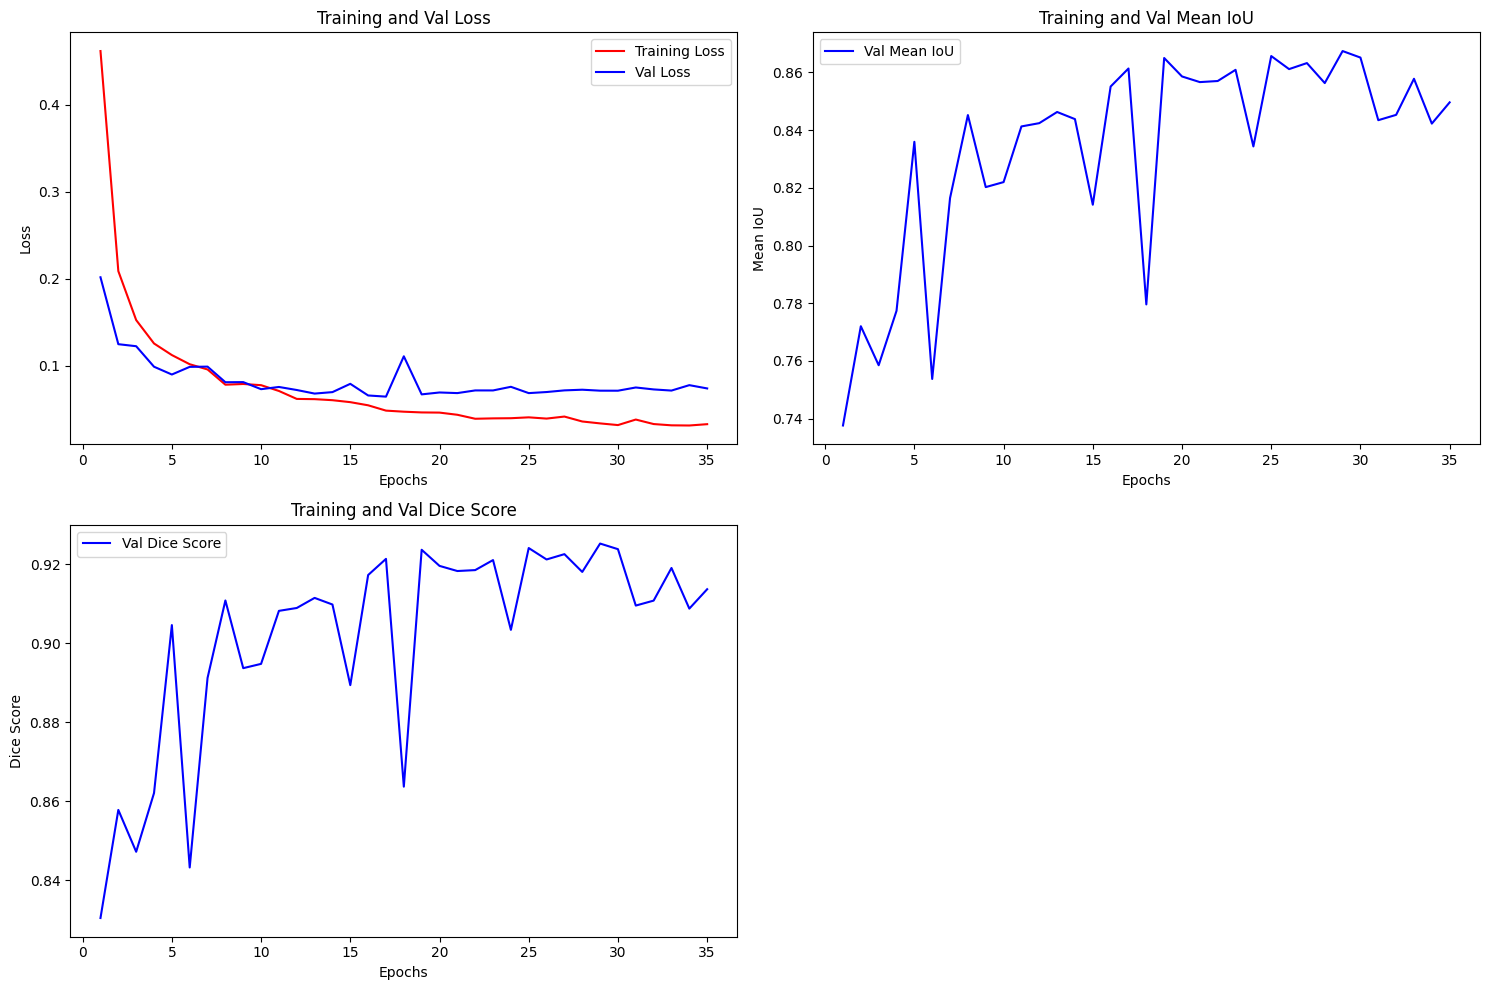

In [79]:
num_class = 1
n_workers = int(os.cpu_count())
# print(n_workers)
batch_size = 16
lr = 1e-4
epochs = 50
checkpoint = "/kaggle/working/tensorboard"
saved_model = "/kaggle/working/saved_model"

train(train_dataset, val_dataset, num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model)

## Inference

In [80]:
import os
import torch
import matplotlib.pyplot as plt

def pred_show_best_worst_per_label(model_pth, device, test_dataset, num_class, top_k=4):
    # Load model checkpoint
    checkpoint = torch.load(model_pth, map_location=device)
    
    # Initialize and load model state
    model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(model_name)
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Dict to store per-category results
    results_by_label = {label: [] for label in test_dataset.categories}

    with torch.no_grad():
        for idx in range(len(test_dataset)):
            ori_img, orig_mask = test_dataset[idx]
            img = ori_img.float().to(device).unsqueeze(0)

            # Predict mask
            pred_mask = upsample(model(img).logits).squeeze()
            pred_mask[pred_mask>=0.5] = 1
            pred_mask[pred_mask<0.5] = 0
            pred_mask = pred_mask.long()

            # Compute IoU
            intersection, union, _ = intersectionAndUnionGPU(pred_mask, orig_mask.long().to(device), K=num_class)
            iou = (intersection / (union + 1e-10)).mean().item()

            # Infer label from file path
            path = test_dataset.path[idx]
            label = os.path.basename(os.path.dirname(path))  # e.g., benign/malignant/normal

            results_by_label[label].append((
                idx,
                iou,
                unNorm(ori_img).permute(1,2,0),
                orig_mask.numpy(),
                pred_mask.cpu().numpy()
            ))

    # Plot best and worst per category
    for label, results in results_by_label.items():
        print(label)
        if not results:
            continue
        results.sort(key=lambda x: x[1])  # sort by IoU

        worst_samples = results[:top_k]
        best_samples = results[-top_k:]

        display_samples = worst_samples + best_samples

        fig = plt.figure(figsize=(20, 6))
        fig.suptitle(f"{label.upper()} - {top_k} Worst and {top_k} Best Predictions", fontsize=16)

        for i, (idx, iou, img, gt, pred) in enumerate(display_samples, 1):
            fig.add_subplot(3, len(display_samples), i)
            plt.imshow(img)
            plt.title(f"Image {idx}\nIoU={iou:.2f}")
            plt.axis("off")

            fig.add_subplot(3, len(display_samples), i + len(display_samples))
            plt.imshow(gt, cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            fig.add_subplot(3, len(display_samples), i + 2*len(display_samples))
            plt.imshow(pred, cmap="gray")
            plt.title("Prediction")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


/tmp/ipykernel_30/1332648244.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth, map_location=device)


benign


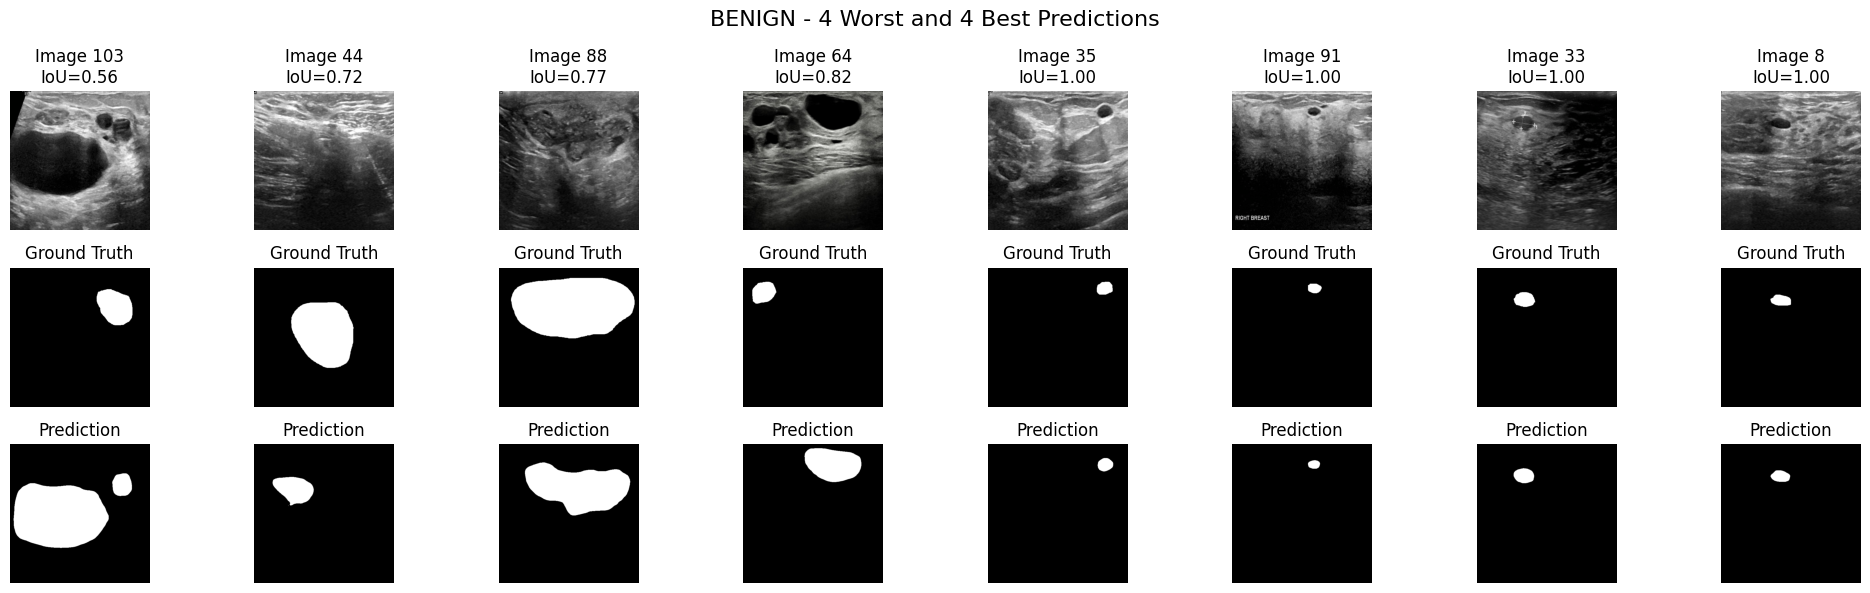

malignant


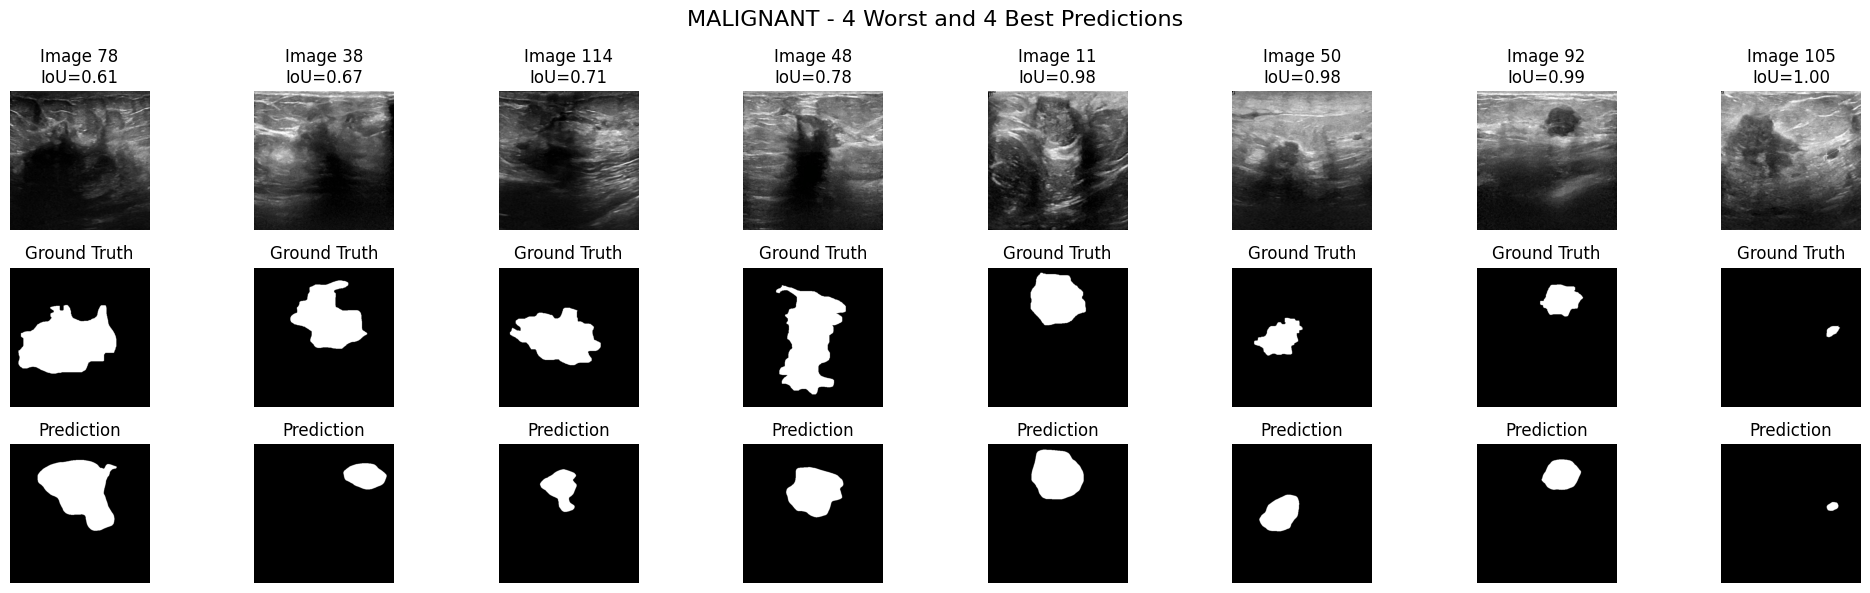

normal


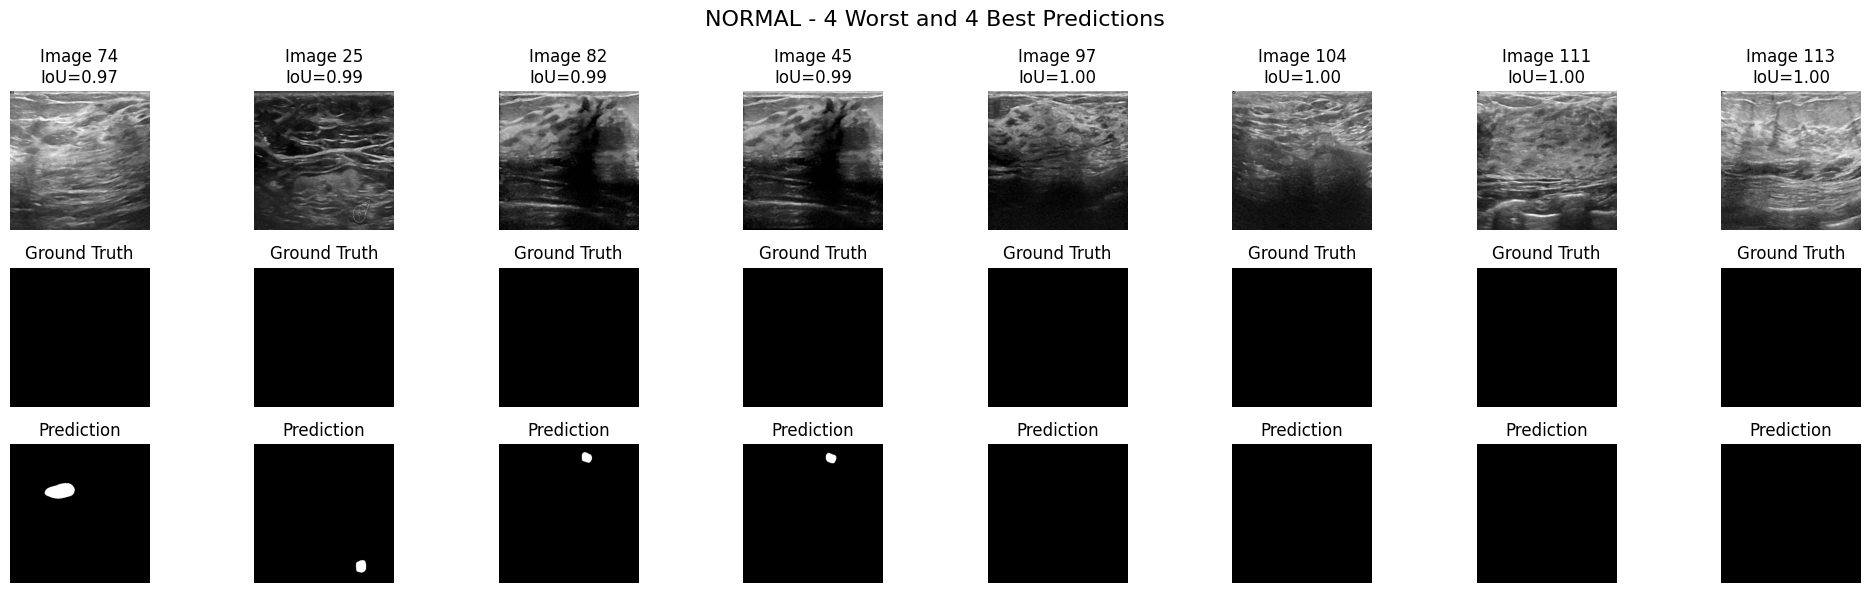

In [81]:
model_pth = "/kaggle/working/saved_model/best.pt"
pred_show_best_worst_per_label(model_pth, device, test_dataset, num_class, top_k=4)

In [82]:
# def pred_show_image_grid(model_pth, device, test_dataset, num_classes, idx, num_imgs):
#     # Load model checkpoint
#     checkpoint = torch.load(model_pth)
    
#     # Initialize and load model state
#     model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
#     model = SegformerForSemanticSegmentation.from_pretrained(model_name)
#     in_channels = model.decode_head.classifier.in_channels
#     model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
#     model.to(device)
    
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
#     # Load validation dataset
    
#     images, orig_masks, pred_masks = [], [], []
    
#     with torch.no_grad():
#         for i in idx:
#             ori_img, orig_mask = test_dataset[i]
#             img = ori_img

#             # Predict mask
#             img = img.float().to(device).unsqueeze(0)
#             # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
#             pred_mask = upsample(model(img).logits).squeeze()
#             pred_mask[pred_mask>=0.5] = 1
#             pred_mask[pred_mask<0.5] = 0
#             pred_mask = pred_mask.long().cpu().numpy()

#             images.append(unNorm(ori_img).permute(1, 2, 0))
#             orig_masks.append(orig_mask)
#             pred_masks.append(pred_mask)

    
#     # Combine images and masks for display
#     images.extend(orig_masks)
#     images.extend(pred_masks)
    
#     # Plot images and masks
#     fig = plt.figure(figsize=(20, 10))
#     for i in range(1, 3*num_imgs + 1):
#         fig.add_subplot(3, num_imgs, i)
#         plt.imshow(images[i - 1])
#     plt.show()

In [ ]:
# import random
# #Note: You must train the model before using this param
# model_pth = "/kaggle/working/saved_model/best.pt"
# print("\n")
# indexs = random.sample(range(len(test_dataset)), 8)
# print("indexs =", indexs)
# print("\n")

# #Show images
# pred_show_image_grid(model_pth, device, test_dataset, num_class, indexs, num_imgs= 8)